In [1]:
import pandas as pd
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.model_selection import KFold
from networkx.readwrite import json_graph
import json
import os

In [2]:
import DIAMOnD as diam
import DIAble as diable

## 1. PPI and GDA data gathering and interactome reconstruction

### 1.1. Download PPIs from BioGRID latest release to build the human interactome

In [3]:
# Load the interactome data from BioGRID
file_path = "BIOGRID-ORGANISM-Homo_sapiens-4.4.229.tab3.txt"
biogrid_data = pd.read_csv(file_path, sep='\t', low_memory=False)

In [4]:
biogrid_data

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Q59H94,NP_001120959|NP_001449,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1,117,84665,88,124185,106603,-,-,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,-,-,-,-,-,-,Homo sapiens,Homo sapiens
2,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,-,NP_002018,-,-,-,-,-,-,Homo sapiens,Homo sapiens
3,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,-,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
4,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,-,NP_644805|NP_003141|NP_001356447|NP_001356443|...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203839,3638573,5566,2534,111553,108810,-,RP1-66H14.1,PRKACA,FYN,PKACA,...,-,NP_002028|NP_001357458|NP_694593|NP_694592,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1203840,3638574,2534,5566,108810,111553,RP1-66H14.1,-,FYN,PRKACA,SLK|SYN|p59-FYN,...,A0A024R7J0,NP_001291278|NP_002721|NP_997401,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1203841,3638575,2534,10142,108810,115445,RP1-66H14.1,-,FYN,AKAP9,SLK|SYN|p59-FYN,...,Q6PJH3|Q5GIA7,NP_005742|NP_671714|NP_001366206,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1203842,3638576,2534,55755,108810,120873,RP1-66H14.1,RP11-412P1.1,FYN,CDK5RAP2,SLK|SYN|p59-FYN,...,Q7Z3M0|B3KVI2|B9EG74,NP_060719|NP_001258968|NP_001011649,-,-,-,-,-,-,Homo sapiens,Homo sapiens


Each line in the file represent an interaction between two proteins. Each protein/interactor is associated to a BioGRID ID, and the same is for the coding gene, which is also associated to its BioGRID Gene ID:
- #BioGRID Interaction ID  : ppi identifier;
- Entrez Gene Interactor A : coding gene A id;
- Entrez Gene Interactor B : coding gene B id;
- BioGRID ID Interactor A  : protein A id;
- BioGRID ID Interactor B  : protein B id;
- Official Symbol Interactor A, Official Symbol Interactor B : protein names for protein A and B;
- Synonyms Interactor A, Synonyms Interactor B : protein synonims for names of protein A and B;
- Experimental System : physical, technical and procedural basis for an experiment;
- Experimental System Type : type of procedure for an experiment;
- Organism ID Interactor A, Organism ID Interactor B : identfiers of the organisms A and B;
- Organism name Interactor A, Organism name Interactor B : names of the organisms A and B.

To build the PPI, each node is represented by a protein as protein's ID, while an edge is defined when two proteins are connected by an interaction line in the file.

#### Filter out all non-human interactions: both “organism A” and “B” fields must be = 9606 (Homo sapiens) & keep only “physical” interactions” (“Experimental System Type” = physical)

In [5]:
# Filter Homo sapiens interactions
biogrid_HI = biogrid_data[(biogrid_data['Organism ID Interactor A'] == 9606) & (biogrid_data['Organism ID Interactor B'] == 9606)]

# Keep only physical interactions
biogrid_PI = biogrid_HI[biogrid_HI['Experimental System Type'] == 'physical']

In [6]:
#print("BioGRID dataset dimensions before dropping duplicates:", biogrid_PI.shape)
# drop duplicates if present
#biogrid_data = biogrid_PI.drop_duplicates()
print("BioGRID PI dataset dimensions:", biogrid_PI.shape)
print("BioGRID dataset dimension before filtering:", biogrid_data.shape)

BioGRID PI dataset dimensions: (1100871, 37)
BioGRID dataset dimension before filtering: (1203844, 37)


In [7]:
biogrid_PI_self = biogrid_PI[(biogrid_PI['BioGRID ID Interactor A'] == biogrid_PI['BioGRID ID Interactor B'])]
print("Self interactions are", biogrid_PI_self.shape[0], "(there might be copies).")

Self interactions are 7393 (there might be copies).


PPI GRAPH with proteins as labels

In [8]:
# Extract nodes
A = np.unique(biogrid_PI['BioGRID ID Interactor A'])
B = np.unique(biogrid_PI['BioGRID ID Interactor B'])
nodes = np.union1d(A, B)

# Extract tuples representing edges
edges = list(zip(biogrid_PI['BioGRID ID Interactor A'], biogrid_PI['BioGRID ID Interactor B']))
print('There are', len(edges), 'edges in the PPI network.')
unique_edges = [tuple(item) for item in set(frozenset(item) for item in edges)]
print("Number of unique edges", len(unique_edges))

There are 1100871 edges in the PPI network.
Number of unique edges 825997


In [9]:
# Cast the IDs of the genes to int
biogrid_PI.loc[:, 'Entrez Gene Interactor A'] = biogrid_PI['Entrez Gene Interactor A'].astype(int)
biogrid_PI.loc[:, 'Entrez Gene Interactor B'] = biogrid_PI['Entrez Gene Interactor B'].astype(int)

In [10]:
# Create a graph from the list of edges (label as proteins codes)
ppi_graph = nx.Graph()
ppi_graph.add_edges_from(edges)

In [11]:
# Remove self loops
ppi_number_nodes = ppi_graph.number_of_nodes()
print("Total number of edges:", ppi_graph.number_of_edges())
print("Total number of nodes:", ppi_number_nodes)
ppi_graph.remove_edges_from(nx.selfloop_edges(ppi_graph))
ppi_number_edges = ppi_graph.number_of_edges()
print("Number of edges without selfloops:", ppi_number_edges)

Total number of edges: 825997
Total number of nodes: 19838
Number of edges without selfloops: 822762


In [12]:
# Find the largest connected component
lcc_ppi = max(nx.connected_components(ppi_graph), key=len)

# Extract the subgraph for the LCC
lcc_ppi_graph = ppi_graph.subgraph(lcc_ppi)

print("The LLC has", lcc_ppi_graph.number_of_edges(), "edges and", lcc_ppi_graph.number_of_nodes(), "nodes.")

The LLC has 822762 edges and 19833 nodes.


In [13]:
for cc in nx.connected_components(ppi_graph):
    print(ppi_graph.subgraph(cc))
    
# Check the number of connected components
num_connected_components = nx.number_connected_components(ppi_graph)
print("Number of connected components:", num_connected_components)

Graph with 19833 nodes and 822762 edges
Graph with 1 nodes and 0 edges
Graph with 1 nodes and 0 edges
Graph with 1 nodes and 0 edges
Graph with 1 nodes and 0 edges
Graph with 1 nodes and 0 edges
Number of connected components: 6


In [14]:
ppi_density = nx.density(ppi_graph)
lcc_density = nx.density(lcc_ppi_graph)
ppi_avg_clust_coeff = nx.average_clustering(ppi_graph)
lcc_avg_clust_coeff = nx.average_clustering(lcc_ppi_graph)

print('PPI graph has:', ppi_density, 'density')
print('LCC graph has:', lcc_density, 'density')
print('PPI graph has:', ppi_avg_clust_coeff, 'average clustering coefficient')
print('LCC graph has:', lcc_avg_clust_coeff, 'average clustering coefficient')

PPI graph has: 0.004181483059106331 density
LCC graph has: 0.004183591724257778 density
PPI graph has: 0.13284824006082055 average clustering coefficient
LCC graph has: 0.13288173177666304 average clustering coefficient


### 1.2. Gather gene-disease associations (GDAs) data from DisGeNET

In [15]:
# Load the data for Steatohepatitis (C2711227) from DisGeNET
file_path_disgenet = "C2711227_disease_gda_summary_CURATED.tsv"
disgenet_data = pd.read_csv(file_path_disgenet, sep='\t', low_memory=False)

In [16]:
disgenet_data

,Disease,Disease_id,Gene,Gene_id,UniProt,Gene_Full_Name,Protein_Class,N_diseases_g,DSI_g,DPI_g,pLI,Score_gda,EL_gda,EI_gda,N_PMIDs,N_SNPs_gda,First_Ref,Last_Ref
0,Steatohepatitis,C2711227,PNPLA3,80339,Q9NST1,patatin like phospholipase domain containing 3,Enzyme,7,0.556,0.692,5.740900e-08,0.50,NaN,0.961,1,1,2009,2020
1,Steatohepatitis,C2711227,APOB,338,P04114,apolipoprotein B,NaN,21,0.453,0.808,1.923400e-16,0.50,NaN,1.000,2,0,1996,2018
2,Steatohepatitis,C2711227,LDLR,3949,P01130,low density lipoprotein receptor,NaN,27,0.449,0.885,9.841000e-24,0.43,NaN,1.000,1,0,2011,2019
3,Steatohepatitis,C2711227,CYP19A1,1588,P11511,cytochrome P450 family 19 subfamily A member 1,Enzyme,51,0.410,0.885,1.702200e-05,0.43,NaN,1.000,1,0,2002,2019
4,Steatohepatitis,C2711227,ATP7B,540,P35670,ATPase copper transporting beta,Transporter,43,0.529,0.654,4.800100e-30,0.42,NaN,1.000,1,0,2007,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,Steatohepatitis,C2711227,MIR219A1,407002,NaN,microRNA 219a-1,NaN,2,0.595,0.615,NaN,0.30,NaN,1.000,1,0,2012,2012
84,Steatohepatitis,C2711227,MIR197,406974,NaN,microRNA 197,NaN,4,0.565,0.615,NaN,0.30,NaN,1.000,1,0,2012,2012
85,Steatohepatitis,C2711227,MIR183,406959,NaN,microRNA 183,NaN,10,0.494,0.885,NaN,0.30,NaN,1.000,1,0,2012,2012
86,Steatohepatitis,C2711227,MIR154,406946,NaN,microRNA 154,NaN,13,0.593,0.577,NaN,0.30,NaN,1.000,1,0,2012,2012


In [17]:
gene_disease = disgenet_data['Gene_id']

In [18]:
print('Total amount of disease genes in Disgenet DB is' , len(gene_disease), 'genes.')

Total amount of disease genes in Disgenet DB is 88 genes.


### 1.3. Compute and characterize the disease LCC and its basic network measures

#### Check for the presence of disease genes in the interactome

In [19]:
# Extract genes in the interactome
gene_A = np.unique(biogrid_PI['Entrez Gene Interactor A'])
gene_B = np.unique(biogrid_PI['Entrez Gene Interactor B'])
genes  = np.union1d(gene_A, gene_B)

# Check if genes associated to disease are in genes list
gene_disease_ppi = set(genes) & set(gene_disease)
print("Out of", len(gene_disease), "disease genes,", len(gene_disease_ppi), "genes are in the interactome.")

Out of 88 disease genes, 76 genes are in the interactome.


#### Identify proteine - coding gene associations 
Two dictionaries are built:
- gene_disease_protein : containing the associations between a gene and its coded protein;
- protein_gene_disease : containing the associations between a protein and its coding gene.

The list of proteins_disease, the ones associated to the genes-disease, are the keys of the second dictionary, memorized in the protein_disease_ppi variable. They represent the node label in the interactome.

In [20]:
# Get the nodes/proteins associated with the disease genes in gene_disease_ppi
# by creating a dictionary from IDs in biogrid df
gene_protein_A = dict(zip(biogrid_PI['Entrez Gene Interactor A'], biogrid_PI['BioGRID ID Interactor A']))
gene_protein_B = dict(zip(biogrid_PI['Entrez Gene Interactor B'], biogrid_PI['BioGRID ID Interactor B']))

# Dictionary with coding genes' IDs as keys and proteins' IDs as values
# merge the two dictionaries
gene_protein = {**gene_protein_A, **gene_protein_B}

# Get the nodes/proteins associated with the disease genes in gene_disease_ppi
# by creating a dictionary from IDs in biogrid df
protein_gene_A = dict(zip(biogrid_PI['BioGRID ID Interactor A'], biogrid_PI['Entrez Gene Interactor A']))
protein_gene_B = dict(zip(biogrid_PI['BioGRID ID Interactor B'], biogrid_PI['Entrez Gene Interactor B']))

# Dictionary with proteins' IDs as keys and coding genes' IDs as values
# merge the two dictionaries
protein_gene = {**protein_gene_A, **protein_gene_B}

In [21]:
# Check if nodes as proteins and coding genes are equal in number
len(gene_protein.keys()) == len(nodes) & len(protein_gene.keys()) == len(nodes)

True

In [22]:
# Extract key-value pairs from the dictionary
gene_disease_protein = {key: gene_protein[key] for key in gene_disease_ppi if key in gene_protein}
print("Coding_gene - protein associations are", len(gene_disease_protein))

# Invert key-value pairs to get protein_gene associations
protein_gene_disease = {value: key for key, value in gene_disease_protein.items()}

# Get the list of the seed proteins 
protein_disease_ppi = list(protein_gene_disease.keys())

Coding_gene - protein associations are 76


#### Identify the disease LCC: get the interactions among disease network; isolate the LCC of the disease network

In [23]:
# Filter the biogrid_PI dataframe of the physical interactions to maintain only the interactions 
# involving disease genes - get the interactions among disease genes only 
biogrid_GDA = biogrid_PI[biogrid_PI['Entrez Gene Interactor A'].isin(gene_disease_ppi) &
                           biogrid_PI['Entrez Gene Interactor B'].isin(gene_disease_ppi)]


In [29]:
# Extract tuples representing edges
edges_GDA = list(zip(biogrid_GDA['Entrez Gene Interactor A'], biogrid_GDA['Entrez Gene Interactor B']))

In [30]:
# Create a graph for disease interactions
disease_graph = nx.Graph()
disease_graph.add_edges_from(edges_GDA)
print('Disease graph has', disease_graph.number_of_edges(), 'edges and', disease_graph.number_of_nodes(), 'nodes.')
#Remove self loops
disease_graph.remove_edges_from(nx.selfloop_edges(disease_graph))
print('After removing self-loops, disease graph has', disease_graph.number_of_edges(), 'edges and', disease_graph.number_of_nodes(), 'nodes.')

Disease graph has 84 edges and 46 nodes.
After removing self-loops, disease graph has 61 edges and 46 nodes.


In [35]:
#Find the largest connected component in the disease network
disease_lcc = max(nx.connected_components(disease_graph), key=len)
    
# Check the number of connected components
num_connected_components = nx.number_connected_components(disease_graph)
print("Number of connected components:", num_connected_components)

Number of connected components: 5


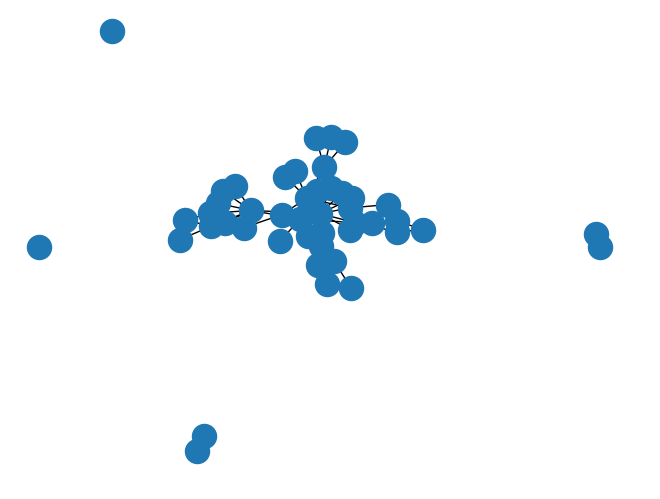

In [40]:
# Increase the spacing among nodes by scaling the layout positions
pos = nx.spring_layout(disease_graph, scale=2)
# Draw the graph with node labels
nx.draw(disease_graph, pos = pos)
# Show the plot
plt.show()

In [44]:
# Create a subgraph with the largest connected component of the disease network
disease_lcc_graph = disease_graph.subgraph(disease_lcc)
# Calculate internal and external node
internal_nodes = disease_lcc_graph.number_of_nodes()
external_nodes = ppi_number_nodes - internal_nodes
# Calculate internal and external edges
internal_edges = disease_lcc_graph.number_of_edges()
external_edges = ppi_number_edges - internal_edges
# Calculate densities
internal_density = nx.density(disease_lcc_graph)
external_density = (2*external_edges) / ((external_nodes - 1) * external_nodes)

print('Disease LCC graph has', internal_edges, 'edges.')
print('Disease LCC graph has', disease_lcc_graph.number_of_nodes(), 'nodes.')
print('Disease LCC graph has', internal_density, 'density.')
print('Disease LCC graph has', nx.average_clustering(disease_lcc_graph), 'average clustering coefficient.')
print('Internal_density:', round(internal_density, 6), ', external_density:', round(external_density, 6))


Disease LCC graph has 59 edges.
Disease LCC graph has 40 nodes.
Disease LCC graph has 0.07564102564102564 density.
Disease LCC graph has 0.25225274725274727 average clustering coefficient.
Internal_density: 0.075641 , external_density: 0.004198


#### Summarize the GDA-related data as in table 1

In [28]:
# Create a dictionary with the data
data = {
    'disease name': ['Steatohepatitis'],  
    'UMLS disease ID': ['C2711227'],  
    'MeSH disease class': ['C02'],  # replace with actual MeSH class
    'number of associated genes': [len(gene_disease)],
    'number of genes present in the interactome': [len(gene_disease_ppi)],
    'LCC size of the disease interactome': [disease_lcc_graph.number_of_nodes()]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)
df

,disease name,UMLS disease ID,MeSH disease class,number of associated genes,number of genes present in the interactome,LCC size of the disease interactome
0,Steatohepatitis,C2711227,C02,88,76,40


#### Compute the following network metrics on the disease LCC:
● Node degree
● Betweenness centrality
● Eigenvector centrality
● Closeness centrality
● ratio Betweenness/Node degree

In [46]:
# Node degree
degree = dict(disease_lcc_graph.degree())

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(disease_lcc_graph)

# Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(disease_lcc_graph)

# Closeness centrality
closeness_centrality = nx.closeness_centrality(disease_lcc_graph)

# Ratio Betweenness/Node degree
ratio = {node: (betweenness_centrality[node] / degree[node]) for node in disease_lcc_graph.nodes()}

metrics = pd.DataFrame({
    'Node Degree': degree,
    'Betweenness Centrality': betweenness_centrality,
    'Eigenvector Centrality': eigenvector_centrality,
    'Closeness Centrality': closeness_centrality,
    'Ratio Betweenness/Node Degree': ratio
})

metrics.head(10)

,Node Degree,Betweenness Centrality,Eigenvector Centrality,Closeness Centrality,Ratio Betweenness/Node Degree
338,5,0.157962,0.191828,0.414894,0.031592
4547,1,0.000000,0.041071,0.295455,0.000000
4609,14,0.625686,0.537770,0.565217,0.044692
1051,2,0.017859,0.135413,0.378641,0.008929
2147,3,0.021368,0.099811,0.339130,0.007123
5054,2,0.015924,0.136508,0.386139,0.007962
1649,4,0.015250,0.094697,0.309524,0.003812
847,5,0.137157,0.257971,0.419355,0.027431
7124,2,0.000000,0.064015,0.295455,0.000000
8431,6,0.088754,0.150694,0.342105,0.014792


#### Report in a table the above network measures of the first 20 disease genes in the disease LCC ordered for node degree from higher to lower, as in table 2

In [47]:
deg_in_lcc_ppi = {}
for gene in degree.keys():
    prot = gene_disease_protein[gene]
    deg_in_lcc_ppi[gene] = lcc_ppi_graph.degree(prot)

In [48]:
# Create a DataFrame with network measures
df_network_measures = pd.DataFrame.from_dict({
    'Gene': list(degree.keys()),
    'Node Degree': list(degree.values()),
    'Node Degree in LCC_ppi': list(deg_in_lcc_ppi.values()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Eigenvector Centrality': list(eigenvector_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values()),
    'Ratio Betweenness/Node Degree': list(ratio.values())
})

# Sort the DataFrame by Node Degree in descending order
df_network_measures = df_network_measures.sort_values(by='Node Degree', ascending=False)

# Get the first 20 rows
df_network_measures.head(20)

,Gene,Node Degree,Node Degree in LCC_ppi,Betweenness Centrality,Eigenvector Centrality,Closeness Centrality,Ratio Betweenness/Node Degree
2,4609,14,2941,0.625686,0.537770,0.565217,0.044692
13,23411,8,379,0.337112,0.309770,0.458824,0.042139
12,330,7,1321,0.155960,0.234980,0.410526,0.022280
9,8431,6,66,0.088754,0.150694,0.342105,0.014792
0,338,5,130,0.157962,0.191828,0.414894,0.031592
29,54205,5,156,0.136100,0.300792,0.458824,0.027220
7,847,5,152,0.137157,0.257971,0.419355,0.027431
17,4780,4,144,0.110301,0.153860,0.390000,0.027575
6,1649,4,117,0.015250,0.094697,0.309524,0.003812
25,6647,4,403,0.032074,0.094665,0.312000,0.008018


#### Visualize the graph and the nodes with highest betweenness centrality.

In [53]:
top_betweennes = df_network_measures.sort_values(by='Betweenness Centrality', ascending=False).head(5)
top_genes = list(top_betweennes['Gene'])

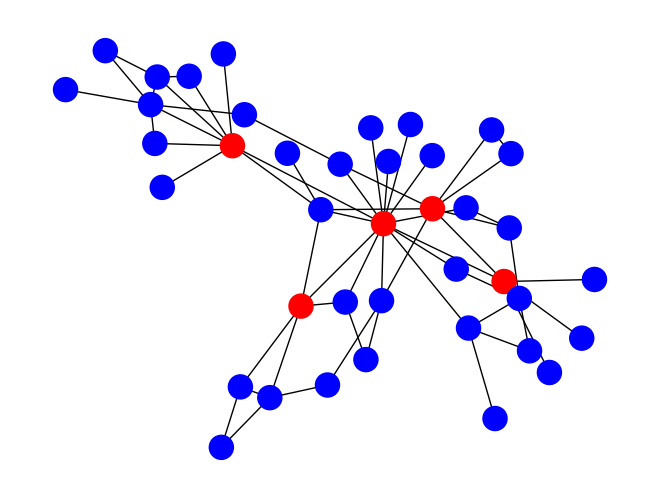

In [55]:
# Increase the spacing among nodes by scaling the layout positions
pos = nx.spring_layout(disease_lcc_graph, scale=2)
# Create a list of colors for all nodes, using a different color for the subset
node_colors = ['red' if node in top_genes else 'blue' for node in disease_lcc_graph.nodes()]
# Draw the graph with node labels
nx.draw(disease_lcc_graph, pos = pos, node_color=node_colors)
# Show the plot
plt.show()

#### Represent node degree and node betweenness in a scatterplot

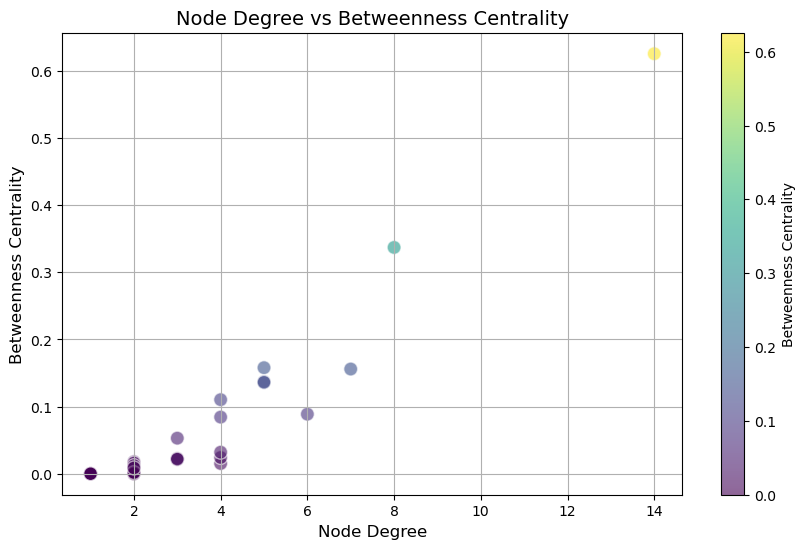

In [32]:
# Convert the values of degree and betweenness centrality to lists
degree_values = list(degree.values())
betweenness_values = list(betweenness_centrality.values())

# Create a scatterplot
plt.figure(figsize=(10, 6))

# Create a color map based on the betweenness centrality
colors = betweenness_values

# Create the scatterplot using the color map
plt.scatter(degree_values, betweenness_values, c=colors, alpha=0.6, edgecolors='w', s=100)

# Add a color bar
cbar = plt.colorbar()
cbar.set_label('Betweenness Centrality')

# Add labels and title
plt.xlabel('Node Degree', fontsize=12)
plt.ylabel('Betweenness Centrality', fontsize=12)
plt.title('Node Degree vs Betweenness Centrality', fontsize=14)

# Add grid
plt.grid(True)

# Show the plot
plt.show()

## 2. Comparative analysis of the disease genes identification algorithms

In [33]:
#  Get the list of proteins/nodes that are not connected to the LCC
disconnected_components = set(ppi_graph.nodes()).difference(set(lcc_ppi_graph.nodes()))
print(disconnected_components)
# Check if the disconnected components are in the seed proteins/genes
p = False
for n in disconnected_components:
    p = p and (n in protein_disease_ppi)

print('The disconnected proteins are encoded by disease genes:', p)

{107592, 117553, 107957, 117306, 122076}
The disconnected proteins are encoded by disease genes: False


Since the nodes in the disconnected components are not in the list of the proteins disease, the **lcc_ppi_graph** will be used for the analysis. 

### 2.1 Connectivity based algorithms for putative disease-genes detection

In the PPI graph, and so also the lcc_ppi_graph, the labels of the nodes have been set to gene names - in any case, the above dictionaries work for gene/protein conversion.

Since it has been prived that there are no disease genes in the disconnected components, the seed genes are all the ones in the interactome, considering the lcc_ppi_graph.

In [34]:
#seed_genes = set(gene_disease_ppi)
# from seed_genes ---> seed_proteins 
seed_proteins = protein_disease_ppi 

In [35]:
ppi_neighbors, ppi_degrees = diable.get_neighbors_and_degrees(lcc_ppi_graph)
lcc_universe = diable.get_universe(seed_proteins, ppi_neighbors)
print('Universe size for DIAOMnD always remains:', len(lcc_ppi_graph.nodes()),'\nInitial Universe size for DIAble:', len(lcc_universe))

Universe size for DIAOMnD always remains: 19833 
Initial Universe size for DIAble: 19382


#### DIAMOnD

In [36]:
# run DIAMOnD
# G_original = lcc_graph, the interactome of the human and physical interactions only
# seed_genes = the proteins coded by the known genes-disease
# max_number_of_added_nodes = deepness of the search - desired number of DIAMOnD genes, 
#                             200 is a reasonable starting point
# alpha = an integer representing weight of the seeds, default value is set to 1
putative_genes_DIAMOnD = "putative_genes_DIAMOnD.txt"
added_nodes = diam.DIAMOnD(lcc_ppi_graph,
                      seed_proteins,
                      max_number_of_added_nodes = 100, alpha = 1,
                      outfile=putative_genes_DIAMOnD)

print("Results have been saved to '%s' \n" % putative_genes_DIAMOnD)

Results have been saved to 'putative_genes_DIAMOnD.txt' 



#### DiaBLE (DIAMOnD Background Local Expansion)
Instead of taking the whole interactome as the background model, DiaBLE considers as gene universe the smallest local expansion of the current seeds set at each iteration step, defyning a new connectivity
significance score by considering an adaptive gene universe.

At each iteration step, only a smaller set of nodes from the interactome is involved in the computations. It is the smaller expansion of the current seed set and consists of:
- the current disease module (seed set);
- the candidate genes (those having at least a link to the current seed set);
- the first neighbors of the candidate genes.

In [37]:
putative_genes_DIAble = "putative_genes_DIAble.txt"
added_nodes_diable = diable.DIAble(lcc_ppi_graph,
                      seed_proteins,
                      max_number_of_added_nodes = 100, alpha = 1,
                      outfile=putative_genes_DIAble)

print("Results have been saved to '%s' \n" % putative_genes_DIAble)

Results have been saved to 'putative_genes_DIAble.txt' 



#### Cytoscape Diffusion Algorithm
Diffusion-based algorithm (available on Cytoscape), diffusion times (arbitrary unit): t=0.002, 0.005, 0.01

https://github.com/idekerlab/heat-diffusion/blob/master/README.md

Heat-diffusion is a cxmate service;
cxMate trasforms CX into data structures native to a programming language of choice and viceversa.

In [38]:
!pip install ndex2 --quiet

In [39]:
import requests
import base64
import ndex2

In [40]:
# Create a Nice CX object from Networkx object
nice_lcc = ndex2.create_nice_cx_from_networkx(lcc_ppi_graph)
# To set seed nodes, add the node attribute diffusion_input with a value of 1.0
c = 0
for nodeid, nodeobj in nice_lcc.get_nodes():
    if nodeid in seed_proteins:
        c += 1
        nice_lcc.remove_node_attribute(node=nodeid, attribute_name='diffusion_input')
        nice_lcc.set_node_attribute(type='double', node=nodeid, attribute_name='diffusion_input', values='1.0')
        
print('Heated nodes are:', c)

Heated nodes are: 76


Call the Diffusion service : here the diffusion service is called. This can take a few minutes to run.

NOTE: Diffusion uses the CXmate service, which requires all attributes to be passed as strings. So we convert the network to CX and stringify attributes

In [41]:
payload = nice_lcc.to_cx()
for p in payload:
    k = list(p.keys())[0]
    if 'Attributes' in k:
        for i in range(len(p[k])):
            p[k][i]['v'] = str(p[k][i]['v'])

# Convert the CX data structure to JSON
cytoscape_cx_json = json.dumps(payload, indent=2)

# Save the JSON data to a file
with open('cytoscape_network.cx', 'w') as file:
    file.write(cytoscape_cx_json)

Generating CX


In [42]:
print('Sending request...')
query_params = {
    'time': 0.01
}
url = 'http://v3.heat-diffusion.cytoscape.io'
response = requests.get(url)

response = requests.post(url, json=payload, params=query_params)

Sending request...


Add results from diffusion to our network : the data dictionary in the json response response.json()['data'] is a dictionary that contains CX formatted data with results of diffussion. This next fragment of code grabs the results of diffusion


In [43]:
for aspect in response.json()['data']:
    if 'nodeAttributes' not in aspect:
        continue
    for n_attr in aspect['nodeAttributes']:
        if n_attr['n'] == 'diffusion_output_rank' or n_attr['n'] == 'diffusion_output_heat':
            if n_attr['d'] == 'float':
                n_type = 'double'
            else:
                n_type = n_attr['d']
            nice_lcc.add_node_attribute(property_of=int(n_attr['po']),
                                 name=n_attr['n'],
                                 values=n_attr['v'],
                                 type=n_type)

Iterates through the nodes of the network looking for the n best hits (by examining diffusion_output_rank).

In [44]:
n = 100
nos = []
for node_id, node in nice_lcc.get_nodes():
    rank = nice_lcc.get_node_attribute_value(node_id, 'diffusion_output_rank')
    if int(rank) < n:
        node['diffusion_output_rank'] = rank
        heat = nice_lcc.get_node_attribute_value(node_id, 'diffusion_output_heat')
        node['diffusion_output_heat'] = float(heat)
        nos.append(node)

# sort the result
nos = sorted(nos, key=lambda k: k['diffusion_output_rank'])       

In [45]:
putative_genes_diffusion = [D['@id'] for D in nos]
putative_genes_diffusion_df = pd.DataFrame(nos)

In [46]:
putative_genes_diffusion_df

,@id,n,diffusion_output_rank,diffusion_output_heat
0,135780,135780,0,0.990132
1,135808,135808,1,0.980349
2,107314,107314,10,0.878842
3,109790,109790,11,0.878322
4,107925,107925,12,0.870096
...,...,...,...,...
95,112258,112258,95,0.017169
96,112488,112488,96,0.016163
97,108341,108341,97,0.015882
98,118984,118984,98,0.015607


In [47]:
def diffusion_write_to_file(diff_nos):
    # Open the file in write mode
    with open('puntative_genes_Cytoscape_t_01.txt', 'w') as f:
        # Write the header
        f.write('diffusion_output_rank\tn\tdiffusion_output_heat\n')

        # Write the sorted data
        for node in diff_nos:
            rank = node['diffusion_output_rank']
            n = node['n']
            heat = node['diffusion_output_heat']
            f.write(f'{rank}\t{n}\t{heat}\n')


In [48]:
diffusion_write_to_file(nos)

Write down as a function the diffusion code to call it in the CV function below.

In [49]:
def cytoscape_diffusion(G, seeds, t, n):
    # Create a Nice CX object from Networkx object
    nice_lcc = ndex2.create_nice_cx_from_networkx(G)

    # To set seed nodes, add the node attribute diffusion_input with a value of 1.0
    for nodeid, nodeobj in nice_lcc.get_nodes():
        if nodeid in seeds: 
            nice_lcc.remove_node_attribute(node=nodeid, attribute_name='diffusion_input')
            nice_lcc.set_node_attribute(type='double', node=nodeid, attribute_name='diffusion_input', values='1.0')

    url = 'http://v3.heat-diffusion.cytoscape.io'
    payload = nice_lcc.to_cx()
    query_params = {
        'time': t
    }

    for p in payload:
        k = list(p.keys())[0]
        if 'Attributes' in k:
            for i in range(len(p[k])):
                p[k][i]['v'] = str(p[k][i]['v'])

    response = requests.post(url, json=payload, params=query_params)

    for aspect in response.json()['data']:
        if 'nodeAttributes' not in aspect:
            continue
        for n_attr in aspect['nodeAttributes']:
            if n_attr['n'] == 'diffusion_output_rank' or n_attr['n'] == 'diffusion_output_heat':
                if n_attr['d'] == 'float':
                    n_type = 'double'
                else:
                    n_type = n_attr['d']
                nice_lcc.add_node_attribute(
                    property_of=int(n_attr['po']),
                    name=n_attr['n'],
                    values=n_attr['v'],
                    type=n_type
                )

    nos = []

    for node_id, node in nice_lcc.get_nodes():
        rank = nice_lcc.get_node_attribute_value(node_id, 'diffusion_output_rank')
        if int(rank) < n:
            node['diffusion_output_rank'] = rank
            heat = nice_lcc.get_node_attribute_value(node_id, 'diffusion_output_heat')
            node['diffusion_output_heat'] = float(heat)
            nos.append(node)

    # Sort the result
    nos = sorted(nos, key=lambda k: int(k['diffusion_output_rank']))
    
    return nos

### 4 fold Cross Validation
Perform a 4-fold cross validation: split the disease genes set S0 into 4 subsets. Each time, select one subset as probe set S_p and the remaining four subsets as training set S_t. Run the algorithm of your choice using the S_t sets and check the output for genes in the S_p set.

In [50]:
def get_module_name(function_name):
    if function_name == 'DIAMOnD':
        return diam
    else:
        return diable
        
def cross_validation_test(n_folds, algo_name, seed_genes, G):
    N = len(seed_genes)
    numbers_putative = [50, int(N/10), int(N/4), int(N/2), N]
    cv_results = dict()
    for number_putative in numbers_putative:
        print('Processing step:', algo_name, 'tops:', number_putative)
        # For the algorithm, initialize a sub_dictionary to contain the results
        cv_results[number_putative] = dict()
        # memorize the results fpr each fold iteration in lists
        precision_distro, recall_distro, f1_score_distro = [], [], []

        # Initialize the KFold object
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        # Iterate over the folds
        for fold, (train_idx, test_idx) in enumerate(kf.split(seed_genes)):
            # Split the dataset into training and test sets
            train_set = [seed_genes[i] for i in train_idx]
            test_set = set([seed_genes[i] for i in test_idx])
            
            # Train and evaluate your model using train_set and test_set
            if (algo_name == "DIAMOnD") or (algo_name == "DIAble"):
                # Get the callable function from its string name and its module name
                module = get_module_name(algo_name)
                model = getattr(module, algo_name)
                # call the algorithm on the train set and extract the results in a suitable shape
                putative_genes = model(G, train_set, number_putative, alpha = 1)
                putative_genes = set([gene_tuple[0] for gene_tuple in putative_genes])
            else:
                time = float(algo_name.split('_')[1])
                putative_genes = cytoscape_diffusion(G, train_set, time, number_putative) 
                putative_genes = set([D['@id'] for D in putative_genes])
            # true positive : correctly identified as disease genes 
            # genes the intersection between the gene in the top X positions and test set
            tp = len(putative_genes & test_set)
            # false positive : erroneously identified as disease genes 
            # genes in the top X positions not present in test set
            fp = len(putative_genes.difference(test_set))
            # false negative : not identified disease genes 
            # genes in test set not present in the top X positions
            fn = len(test_set.difference(putative_genes))
            print('tp:', tp, 'fp:', fp, 'fn:', fn )
            precision = tp/(tp + fp)
            recall = tp/(tp + fn)
            if (precision + recall == 0):
                f1_score = -1
            else:
                f1_score = (2*precision*recall)/(precision + recall)
            precision_distro.append(precision)
            recall_distro.append(recall)
            f1_score_distro.append(f1_score)
        cv_results[number_putative]['precision'] = round(np.mean(precision_distro) + np.std(precision_distro), 5)
        cv_results[number_putative]['recall'] = round(np.mean(recall_distro) + np.std(recall_distro), 5)
        cv_results[number_putative]['f1_score'] = round(np.mean(f1_score_distro) + np.std(f1_score_distro), 5)
    return(cv_results)

In [51]:
# Parallelize cross-validation using joblib
algorithms = ['DIAMOnD', 'DIAble', 'Cytoscape_0.002', 'Cytoscape_0.005', 'Cytoscape_0.01']

In [60]:
cv_diamond = cross_validation_test(4, 'DIAMOnD', seed_proteins, lcc_ppi_graph)

Processing step: DIAMOnD tops: 50
tp: 1 fp: 49 fn: 18
tp: 2 fp: 48 fn: 17
tp: 2 fp: 48 fn: 17
tp: 3 fp: 47 fn: 16
Processing step: DIAMOnD tops: 7
tp: 0 fp: 7 fn: 19
tp: 1 fp: 6 fn: 18
tp: 1 fp: 6 fn: 18
tp: 0 fp: 7 fn: 19
Processing step: DIAMOnD tops: 19
tp: 0 fp: 19 fn: 19
tp: 2 fp: 17 fn: 17
tp: 1 fp: 18 fn: 18
tp: 1 fp: 18 fn: 18
Processing step: DIAMOnD tops: 38
tp: 0 fp: 38 fn: 19
tp: 2 fp: 36 fn: 17
tp: 1 fp: 37 fn: 18
tp: 3 fp: 35 fn: 16
Processing step: DIAMOnD tops: 76
tp: 1 fp: 75 fn: 18
tp: 2 fp: 74 fn: 17
tp: 2 fp: 74 fn: 17
tp: 4 fp: 72 fn: 15


In [61]:
cv_diamond = pd.DataFrame(cv_diamond).T
cv_diamond

,precision,recall,f1_score
50,0.05414,0.14248,0.07847
7,0.14286,0.05263,0.07692
19,0.08985,0.08985,0.26653
38,0.06890,0.13779,0.26669
76,0.04394,0.17577,0.07031


In [62]:
cv_diable = cross_validation_test(4, 'DIAble', seed_proteins, lcc_ppi_graph)

Processing step: DIAble tops: 50
tp: 1 fp: 49 fn: 18
tp: 2 fp: 48 fn: 17
tp: 2 fp: 48 fn: 17
tp: 3 fp: 47 fn: 16
Processing step: DIAble tops: 7
tp: 0 fp: 7 fn: 19
tp: 1 fp: 6 fn: 18
tp: 1 fp: 6 fn: 18
tp: 0 fp: 7 fn: 19
Processing step: DIAble tops: 19
tp: 0 fp: 19 fn: 19
tp: 2 fp: 17 fn: 17
tp: 1 fp: 18 fn: 18
tp: 1 fp: 18 fn: 18
Processing step: DIAble tops: 38
tp: 0 fp: 38 fn: 19
tp: 2 fp: 36 fn: 17
tp: 1 fp: 37 fn: 18
tp: 3 fp: 35 fn: 16
Processing step: DIAble tops: 76
tp: 1 fp: 75 fn: 18
tp: 2 fp: 74 fn: 17
tp: 2 fp: 74 fn: 17
tp: 3 fp: 73 fn: 16


In [63]:
cv_diable = pd.DataFrame(cv_diable).T
cv_diable

,precision,recall,f1_score
50,0.05414,0.14248,0.07847
7,0.14286,0.05263,0.07692
19,0.08985,0.08985,0.26653
38,0.06890,0.13779,0.26669
76,0.03562,0.14248,0.05699


In [52]:
cv_cyto002 = cross_validation_test(4, 'Cytoscape_0.002', seed_proteins, lcc_ppi_graph)

Processing step: Cytoscape_0.002 tops: 50
Generating CX
tp: 0 fp: 50 fn: 19
Generating CX
tp: 0 fp: 50 fn: 19
Generating CX
tp: 0 fp: 50 fn: 19
Generating CX
tp: 0 fp: 50 fn: 19
Processing step: Cytoscape_0.002 tops: 7
Generating CX
tp: 0 fp: 7 fn: 19
Generating CX
tp: 0 fp: 7 fn: 19
Generating CX
tp: 0 fp: 7 fn: 19
Generating CX
tp: 0 fp: 7 fn: 19
Processing step: Cytoscape_0.002 tops: 19
Generating CX
tp: 0 fp: 19 fn: 19
Generating CX
tp: 0 fp: 19 fn: 19
Generating CX
tp: 0 fp: 19 fn: 19
Generating CX
tp: 0 fp: 19 fn: 19
Processing step: Cytoscape_0.002 tops: 38
Generating CX
tp: 0 fp: 38 fn: 19
Generating CX
tp: 0 fp: 38 fn: 19
Generating CX
tp: 0 fp: 38 fn: 19
Generating CX
tp: 0 fp: 38 fn: 19
Processing step: Cytoscape_0.002 tops: 76
Generating CX
tp: 1 fp: 75 fn: 18
Generating CX
tp: 1 fp: 75 fn: 18
Generating CX
tp: 0 fp: 76 fn: 19
Generating CX
tp: 0 fp: 76 fn: 19


In [54]:
cv_cyto002 = pd.DataFrame(cv_cyto002).T
cv_cyto002

,precision,recall,f1_score
50,0.00000,0.00000,-1.00000
7,0.00000,0.00000,-1.00000
19,0.00000,0.00000,-1.00000
38,0.00000,0.00000,-1.00000
76,0.01316,0.05263,0.02105


In [55]:
cv_cyto005 = cross_validation_test(4, 'Cytoscape_0.005', seed_proteins, lcc_ppi_graph)

Processing step: Cytoscape_0.005 tops: 50
Generating CX
tp: 0 fp: 50 fn: 19
Generating CX
tp: 0 fp: 50 fn: 19
Generating CX
tp: 0 fp: 50 fn: 19
Generating CX
tp: 0 fp: 50 fn: 19
Processing step: Cytoscape_0.005 tops: 7
Generating CX
tp: 0 fp: 7 fn: 19
Generating CX
tp: 0 fp: 7 fn: 19
Generating CX
tp: 0 fp: 7 fn: 19
Generating CX
tp: 0 fp: 7 fn: 19
Processing step: Cytoscape_0.005 tops: 19
Generating CX
tp: 0 fp: 19 fn: 19
Generating CX
tp: 0 fp: 19 fn: 19
Generating CX
tp: 0 fp: 19 fn: 19
Generating CX
tp: 0 fp: 19 fn: 19
Processing step: Cytoscape_0.005 tops: 38
Generating CX
tp: 0 fp: 38 fn: 19
Generating CX
tp: 0 fp: 38 fn: 19
Generating CX
tp: 0 fp: 38 fn: 19
Generating CX
tp: 0 fp: 38 fn: 19
Processing step: Cytoscape_0.005 tops: 76
Generating CX
tp: 1 fp: 75 fn: 18
Generating CX
tp: 1 fp: 75 fn: 18
Generating CX
tp: 1 fp: 75 fn: 18
Generating CX
tp: 0 fp: 76 fn: 19


In [56]:
cv_cyto005 = pd.DataFrame(cv_cyto005).T
cv_cyto005

,precision,recall,f1_score
50,0.00000,0.00000,-1.00000
7,0.00000,0.00000,-1.00000
19,0.00000,0.00000,-1.00000
38,0.00000,0.00000,-1.00000
76,0.01557,0.06226,0.20792


In [57]:
cv_cyto01 = cross_validation_test(4, 'Cytoscape_0.01', seed_proteins, lcc_ppi_graph)

Processing step: Cytoscape_0.01 tops: 50
Generating CX
tp: 0 fp: 50 fn: 19
Generating CX
tp: 0 fp: 50 fn: 19
Generating CX
tp: 0 fp: 50 fn: 19
Generating CX
tp: 0 fp: 50 fn: 19
Processing step: Cytoscape_0.01 tops: 7
Generating CX
tp: 0 fp: 7 fn: 19
Generating CX
tp: 0 fp: 7 fn: 19
Generating CX
tp: 0 fp: 7 fn: 19
Generating CX
tp: 0 fp: 7 fn: 19
Processing step: Cytoscape_0.01 tops: 19
Generating CX
tp: 0 fp: 19 fn: 19
Generating CX
tp: 0 fp: 19 fn: 19
Generating CX
tp: 0 fp: 19 fn: 19
Generating CX
tp: 0 fp: 19 fn: 19
Processing step: Cytoscape_0.01 tops: 38
Generating CX
tp: 0 fp: 38 fn: 19
Generating CX
tp: 0 fp: 38 fn: 19
Generating CX
tp: 0 fp: 38 fn: 19
Generating CX
tp: 0 fp: 38 fn: 19
Processing step: Cytoscape_0.01 tops: 76
Generating CX
tp: 0 fp: 76 fn: 19
Generating CX
tp: 1 fp: 75 fn: 18
Generating CX
tp: 1 fp: 75 fn: 18
Generating CX
tp: 0 fp: 76 fn: 19


In [59]:
cv_cyto01 = pd.DataFrame(cv_cyto01).T
cv_cyto01

,precision,recall,f1_score
50,0.00000,0.00000,-1.00000
7,0.00000,0.00000,-1.00000
19,0.00000,0.00000,-1.00000
38,0.00000,0.00000,-1.00000
76,0.01316,0.05263,0.02105


In [66]:
from functools import reduce

In [75]:
# List of DataFrames
dfs = [cv_diamond, cv_diable, cv_cyto005, cv_cyto002, cv_cyto01]
dfs_names = ['diamond', 'diable', 'cyto005', 'cyto002', 'cyto01']

# Add a 'source' column to identify the original DataFrame
for i, df in enumerate(dfs):
    df['source'] = f'{dfs_names[i]}'

# Use reduce to concatenate DataFrames along rows (axis 0)
cv_results = reduce(lambda left, right: pd.concat([left, right], axis=0), dfs)
cv_results_filtered = cv_results[cv_results['f1_score'] != -1]
cv_results_filtered = cv_results_filtered.sort_values(by='precision', ascending=False)
cv_results_filtered

,precision,recall,f1_score,source
7,0.14286,0.05263,0.07692,diamond
7,0.14286,0.05263,0.07692,diable
19,0.08985,0.08985,0.26653,diamond
19,0.08985,0.08985,0.26653,diable
38,0.06890,0.13779,0.26669,diamond
38,0.06890,0.13779,0.26669,diable
50,0.05414,0.14248,0.07847,diamond
50,0.05414,0.14248,0.07847,diable
76,0.04394,0.17577,0.07031,diamond
76,0.03562,0.14248,0.05699,diable


## 3. Putative disease gene identification

In [76]:
!pip install gseapy --quiet

In [77]:
import gseapy as gp

### 3.2 Enrichment Analysis
#### Perform the enrichment analysis (via EnrichR: GO BP, MF, CC, and KEGG pathways) over the putative disease genes

In [94]:
putative_proteins_diable = [el[0] for el in added_nodes_diable]
# Convert proteins ids to gene ids
putative_genes_diable = [protein_gene[prot] for prot in putative_proteins_diable]

In [115]:
# Convert the list of gene IDs to a comma-separated string
putative_gene_ids_str = ','.join(map(str, putative_genes_diable))

# Define the headers and parameters for the POST request
headers = {'content-type': 'application/x-www-form-urlencoded'}
params = f'ids={putative_gene_ids_str}&fields=name,symbol,refseq.rna'

# Send the POST request
res = requests.post('http://mygene.info/v3/gene', data=params, headers=headers)

# Parse the response
response_data = res.json()

# Extract the gene symbols from the response
putative_gene_data = {item['_id'] : item['symbol'] for item in response_data}
putative_gene_symbols = [value for key, value in putative_gene_data.items()]

In [118]:
# Run Enrichr
enr_putative = gp.enrichr(
    gene_list=putative_gene_symbols,
    gene_sets=['GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018', 'KEGG_2019_Human'],
    organism='Human',  
    outdir='enrichr_kegg',
    cutoff=0.05  # test dataset, use lower value from range(0,1)
)

C:\Users\utente\anaconda3\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
C:\Users\utente\anaconda3\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
C:\Users\utente\anaconda3\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
C:\Users\utente\anaconda3\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


In [119]:
enr_putative.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,regulation of transcription from RNA polymeras...,74/1478,3.613511e-62,3.476197e-59,0,0,37.494631,5304.575227,RARG;SMARCB1;THRB;ETS1;SOX17;TRPS1;HNF4A;EP300...
1,GO_Biological_Process_2018,"positive regulation of transcription, DNA-temp...",66/1120,3.536513e-58,1.701063e-55,0,0,34.709119,4591.558122,RARG;SMARCB1;THRB;ETS1;SOX17;HNF4A;EP300;SOX9;...
2,GO_Biological_Process_2018,positive regulation of transcription from RNA ...,57/848,6.216331e-52,1.993370e-49,0,0,32.023432,3775.794666,RARG;SMARCB1;THRB;ETS1;SOX17;HNF4A;EP300;SOX9;...
3,GO_Biological_Process_2018,"regulation of transcription, DNA-templated (GO...",61/1598,1.613814e-41,3.881222e-39,0,0,18.686802,1755.202559,SMARCB1;CHD7;ETS1;SOX17;BCL7A;HNF4A;EP300;SOX9...
4,GO_Biological_Process_2018,positive regulation of nucleic acid-templated ...,38/502,5.173340e-35,9.953505e-33,0,0,25.673248,2026.824883,SMARCD3;GATA3;ETS1;RELA;SOX17;HNF4A;NRIP1;EP30...
...,...,...,...,...,...,...,...,...,...,...
1278,KEGG_2019_Human,Alcoholism,1/180,5.959949e-01,6.160283e-01,0,0,1.112860,0.575931,HDAC3
1279,KEGG_2019_Human,Focal adhesion,1/199,6.330305e-01,6.472523e-01,0,0,1.005102,0.459569,JUN
1280,KEGG_2019_Human,Proteoglycans in cancer,1/201,6.367278e-01,6.472523e-01,0,0,0.994949,0.449133,MDM2
1281,KEGG_2019_Human,Herpes simplex virus 1 infection,2/492,7.089719e-01,7.147831e-01,0,0,0.808413,0.278045,RELA;NFKB1


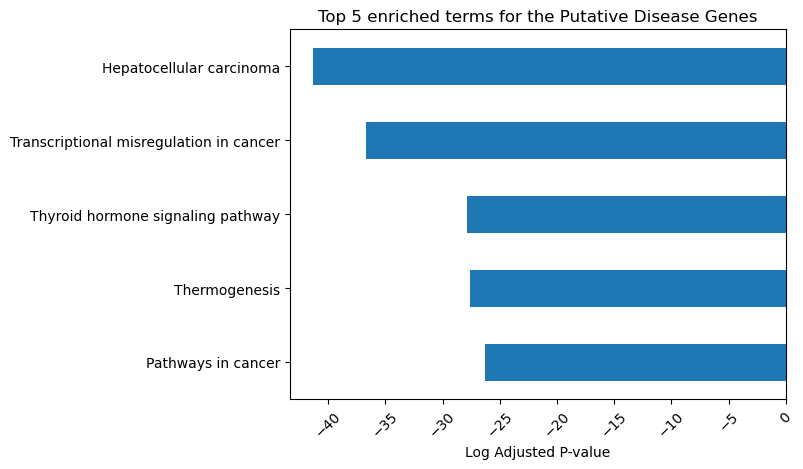

In [189]:
# You can create a bar plot for the top 5 enriched terms
top5 = enr_putative.res2d.sort_values('Adjusted P-value', ascending=True).head(5)
top5['Log Adjusted P-value'] = np.log(top5['Adjusted P-value'])
top5.plot.barh(y='Log Adjusted P-value', x='Term', legend=False)
plt.gca().invert_yaxis()
plt.xlabel('Log Adjusted P-value')
plt.xticks(x = 'Term', rotation=45)
plt.ylabel('')
plt.title('Top 5 enriched terms for the Putative Disease Genes')
plt.show()

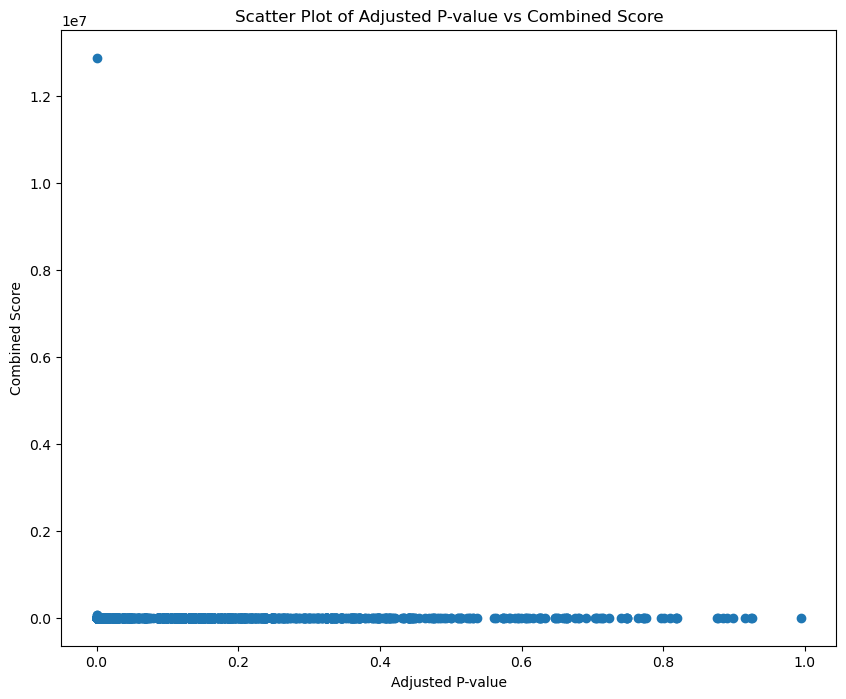

In [121]:
# Create the bubble chart
plt.figure(figsize=(10, 8))
plt.scatter(enr_putative.results['Adjusted P-value'], enr_putative.results['Combined Score'])
plt.xlabel('Adjusted P-value')
plt.ylabel('Combined Score')
plt.title('Scatter Plot of Adjusted P-value vs Combined Score')
plt.show()

In [190]:
# Define your thresholds
combined_score_threshold = 1.2e7  # adjust this value based on your scatter plot
adjusted_p_value_threshold = 0.05  # adjust this value based on your scatter plot

# Filter the DataFrame
outliers = enr_putative.results[(enr_putative.results['Combined Score'] > combined_score_threshold) & (enr_putative.results['Adjusted P-value'] < adjusted_p_value_threshold)]

outliers

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
966,GO_Cellular_Component_2018,npBAF complex (GO:0071564),11/11,2.763489e-26,3.039838e-25,0,0,218900.0,1.288242e+07,SMARCE1;SMARCD1;SMARCC1;SMARCD3;SMARCC2;SMARCB...


In [191]:
sorted_df = enr_putative.results.sort_values(by=['Combined Score', 'Adjusted P-value'], ascending=[False, True])

# Print the top rows
print(sorted_df.head())

                       Gene_set                                 Term Overlap  \
966  GO_Cellular_Component_2018           npBAF complex (GO:0071564)   11/11   
964  GO_Cellular_Component_2018        BAF-type complex (GO:0090544)   14/17   
967  GO_Cellular_Component_2018         SWI/SNF complex (GO:0016514)   12/15   
9    GO_Biological_Process_2018  nucleosome disassembly (GO:0006337)   11/19   
10   GO_Biological_Process_2018   chromatin disassembly (GO:0031498)   11/19   

          P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
966  2.763489e-26      3.039838e-25            0                     0   
964  1.583249e-30      2.902623e-29            0                     0   
967  5.530684e-26      5.069794e-25            0                     0   
9    2.022612e-21      1.768866e-19            0                     0   
10   2.022612e-21      1.768866e-19            0                     0   

        Odds Ratio  Combined Score  \
966  218900.000000    1.288242e+07  

#### Perform the enrichment analysis (via EnrichR: GO BP, MF, CC, and KEGG pathways) for the original disease genes gathered at point 1.2

In [100]:
gene_ids = gene_disease.tolist()

# Convert the list of gene IDs to a comma-separated string
gene_ids_str = ','.join(map(str, gene_ids))

# Define the headers and parameters for the POST request
headers = {'content-type': 'application/x-www-form-urlencoded'}
params = f'ids={gene_ids_str}&fields=name,symbol,refseq.rna'

# Send the POST request
res = requests.post('http://mygene.info/v3/gene', data=params, headers=headers)

# Parse the response
response_data = res.json()

# Extract the gene symbols from the response
gene_symbols = [item['symbol'] for item in response_data]

In [101]:
# Run Enrichr
enr_disease = gp.enrichr(
    gene_list=gene_symbols,
    gene_sets=['GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018', 'KEGG_2019_Human'],
    organism='Human',  
    outdir='enrichr_kegg',
    cutoff=0.05  # test dataset, use lower value from range(0,1)
)

C:\Users\utente\anaconda3\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
C:\Users\utente\anaconda3\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
C:\Users\utente\anaconda3\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
C:\Users\utente\anaconda3\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


In [102]:
enr_disease.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,cellular response to lipopolysaccharide (GO:00...,10/91,7.722359e-12,1.179976e-08,0,0,31.388097,803.124151,XBP1;CXCL8;NR1I2;SERPINE1;NR1H4;NR1H3;CCL2;NR1...
1,GO_Biological_Process_2018,"positive regulation of transcription, DNA-temp...",24/1120,5.311838e-11,4.058244e-08,0,0,6.437956,152.312374,FOXA1;SREBF1;XBP1;CEBPB;NR1I2;SERPINE1;F2R;IFN...
2,GO_Biological_Process_2018,cellular response to molecule of bacterial ori...,9/84,1.142843e-10,4.968104e-08,0,0,30.132152,689.795234,XBP1;CXCL8;SERPINE1;NR1I2;NR1H4;CCL2;NR1H3;NR1...
3,GO_Biological_Process_2018,sterol homeostasis (GO:0055092),8/58,1.625689e-10,4.968104e-08,0,0,39.724000,895.375762,XBP1;NR1I2;NR1H4;NR1H3;CYP7B1;APOB;SIRT1;LDLR
4,GO_Biological_Process_2018,cholesterol homeostasis (GO:0042632),8/58,1.625689e-10,4.968104e-08,0,0,39.724000,895.375762,XBP1;NR1I2;NR1H4;NR1H3;CYP7B1;APOB;SIRT1;LDLR
...,...,...,...,...,...,...,...,...,...,...
1970,KEGG_2019_Human,Alcoholism,1/180,5.494685e-01,5.617471e-01,0,0,1.267129,0.758762,ATF4
1971,KEGG_2019_Human,Calcium signaling pathway,1/188,5.652274e-01,5.746479e-01,0,0,1.212429,0.691723,F2R
1972,KEGG_2019_Human,Viral carcinogenesis,1/201,5.896813e-01,5.961971e-01,0,0,1.132874,0.598353,ATF4
1973,KEGG_2019_Human,Thermogenesis,1/231,6.410442e-01,6.445664e-01,0,0,0.983608,0.437368,FGF21


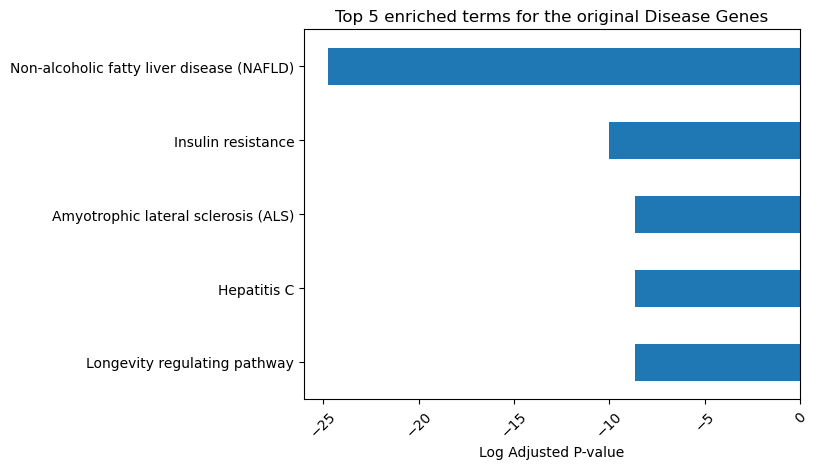

In [194]:
# You can create a bar plot for the top 5 enriched terms
top5 = enr_disease.res2d.sort_values('Adjusted P-value', ascending=True).head(5)

# Apply a log transformation to the P-values
top5['Log Adjusted P-value'] = np.log(top5['Adjusted P-value'])

# Create the bar plot
top5.plot.barh(y='Log Adjusted P-value', x='Term', legend=False)
plt.gca().invert_yaxis()
plt.xlabel('Log Adjusted P-value')
plt.xticks(rotation=45)
plt.ylabel('')
plt.title('Top 5 enriched terms for the original Disease Genes')
plt.show()

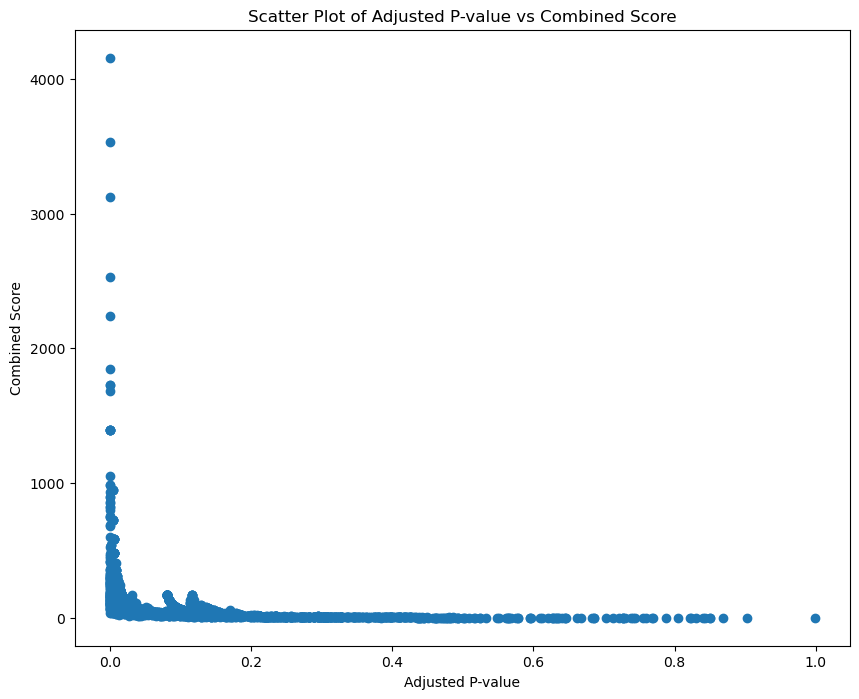

In [104]:
# Create the bubble chart
plt.figure(figsize=(10, 8))
plt.scatter(enr_disease.results['Adjusted P-value'], enr_disease.results['Combined Score'])
plt.xlabel('Adjusted P-value')
plt.ylabel('Combined Score')
plt.title('Scatter Plot of Adjusted P-value vs Combined Score')
plt.show()

In [195]:
# Define your thresholds
combined_score_threshold = 2000  # adjust this value based on your scatter plot
adjusted_p_value_threshold = 0.05  # adjust this value based on your scatter plot

# Filter the DataFrame
outliers = enr_disease.results[(enr_disease.results['Combined Score'] > combined_score_threshold) & (enr_disease.results['Adjusted P-value'] < adjusted_p_value_threshold)]

outliers

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
7,GO_Biological_Process_2018,PERK-mediated unfolded protein response (GO:00...,5/12,1.135979e-09,2.169719e-07,0,0,171.299484,3528.044978,CXCL8;DDIT3;CCL2;NFE2L2;ATF4
13,GO_Biological_Process_2018,response to leptin (GO:0044321),4/8,2.416110e-08,2.637012e-06,0,0,237.000000,4156.629689,LEP;LEPR;NR1D1;SIRT1
37,GO_Biological_Process_2018,cellular triglyceride homeostasis (GO:0035356),3/6,1.630456e-06,6.556150e-05,0,0,234.223529,3121.415164,XBP1;NR1H4;SIRT1
40,GO_Biological_Process_2018,cellular response to leptin stimulus (GO:0044320),3/7,2.844226e-06,1.059995e-04,0,0,175.658824,2243.201729,LEP;LEPR;SIRT1
1611,GO_Molecular_Function_2018,RNA polymerase II transcription factor activit...,6/19,1.580957e-10,1.438670e-08,0,0,112.001876,2527.638275,NR1I2;NR1H4;NR1H3;NR1D1;PPARA;PPARD


#### Overlap Evaluation between DIAble Putative genes and Original Disease genes

In [124]:
# Get the enriched terms for the original and putative genes
original_terms = set(enr_disease.results['Term'])
putative_terms = set(enr_putative.results['Term'])

# Calculate the overlap
overlap = original_terms.intersection(putative_terms)
len(overlap)

693

For a more rigorous comparison, can be used a statistical test, such as Fisher’s exact test, to compare the overlaps. This would give you a p-value for the difference in overlap between the two sets.

In [125]:
from scipy.stats import fisher_exact

# Get the counts of terms for each set
original_count = len(original_terms)
putative_count = len(putative_terms)
overlap_count = len(overlap)

# Get the total number of terms in the universe (this would be the total number of possible enriched functions)
total_terms = len(enr_disease.results['Term'].unique().tolist() + enr_putative.results['Term'].unique().tolist())

# Create a contingency table
contingency_table = [[overlap_count, original_count - overlap_count], 
                     [putative_count - overlap_count, total_terms - original_count - putative_count + overlap_count]]

# Perform Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table)

# Print the results
print(f'The p-value for the overlap is: {p_value}')

The p-value for the overlap is: 6.707382402370961e-10


The p-value is extremely small (6.707382402370961e-10), much less than 0.05. This indicates that the overlap between the enriched functions of original disease genes and putative disease genes is statistically significant, and the likelihood that this overlap could have occurred by chance is extremely low.

However, while a low p-value indicates statistical significance, it does not measure the size of the effect or the importance of a result.


In [127]:
jaccard_index = len(overlap) / (len(original_terms) + len(putative_terms) - len(overlap))
round(jaccard_index, 5)

0.27018

A Jaccard Index of 0.27018 means that approximately 27% of the total unique enriched functions in both the original disease genes and putative disease genes are common to both sets.

This suggests a modest overlap between the two sets of enriched functions.

### 4. Drug repurpoising
#### 4.1 Drug identification

Select the first 20 putative disease genes in the ranking obtained at point 3.1;

Use DGIdb (dgidb.org) to associate such 20 genes to approved drugs (access the db manually or via API);

Compile a ranking of the identified drugs, starting from the drug associated with the most of the above 20 genes going down.

In [155]:
file_pgen = pd.read_csv('putative_genes_DIAble.txt',sep='\t')
all_putative_genes = pd.DataFrame(file_pgen)
top_20_putative_genes = all_putative_genes[:20]
top_20_putative_genes

,#rank,DIAble_node,p_hyper,universe_len
0,1,112170,4.408352e-09,19382
1,2,114974,2.391428e-08,19383
2,3,114973,1.793318e-08,19385
3,4,113841,1.760815e-09,19389
4,5,113222,2.770422e-10,19396
5,6,112168,2.893173e-11,19398
6,7,113264,1.451575e-09,19399
7,8,114200,1.292136e-10,19401
8,9,112169,1.409008e-10,19406
9,10,111851,1.010759e-11,19407


In [153]:
diable_20_proteins = putative_proteins_diable[:20]
diable_20_genes = [protein_gene[prot] for prot in diable_20_proteins]
genes_symbols_20 = [putative_gene_data[str(key)] for key in diable_20_genes]
genes_symbols_20

['RXRG',
 'NCOR2',
 'NCOR1',
 'NCOA3',
 'NR1H2',
 'RXRA',
 'VDR',
 'NCOA1',
 'RXRB',
 'RARG',
 'PPARG',
 'RARA',
 'NCOA6',
 'PPARGC1A',
 'RARB',
 'THRB',
 'NCOA2',
 'CREBBP',
 'NRIP1',
 'EP300']

In [166]:
file_path = "interactions.tsv"
gene_drug_data = pd.read_csv(file_path, sep='\t', low_memory=False)

In [167]:
gene_drug_data

,gene_name,gene_claim_name,entrez_id,interaction_claim_source,interaction_types,drug_claim_name,drug_claim_primary_name,drug_name,drug_concept_id,interaction_group_score,PMIDs
0,CDK7,CDK7,1022.0,CancerCommons,inhibitor,SNS-032,SNS-032,BMS-387032,chembl:CHEMBL296468,0.82,NaN
1,VDR,VDR,7421.0,DTC,NaN,NIFEKALANT,NIFEKALANT,NIFEKALANT,chembl:CHEMBL360861,0.14,NaN
2,GPR55,GPR55,9290.0,DTC,NaN,BISACODYL,BISACODYL,BISACODYL,chembl:CHEMBL942,0.94,NaN
3,NR1H4,NR1H4,9971.0,DTC,NaN,PENTACHLOROPHENOL,PENTACHLOROPHENOL,PENTACHLOROPHENOL,chembl:CHEMBL75967,0.07,NaN
4,FGFR2,FGFR2,2263.0,JAX-CKB,NaN,AZ6089,AZ6089,NaN,NaN,NaN,22869148
...,...,...,...,...,...,...,...,...,...,...,...
85455,PIK3C3,PIK3C3,5289.0,MyCancerGenome,inhibitor,BGJ398,BGJ398,INFIGRATINIB,chembl:CHEMBL1852688,0.17,NaN
85456,ABL1,Tyrosine-protein kinase ABL1,25.0,TTD,NaN,Azaindole derivative 2,Azaindole derivative 2,NaN,NaN,NaN,NaN
85457,CACNA1D,776,776.0,GuideToPharmacology,inhibitor,135651166,[3H](+)-ISRADIPINE,NaN,NaN,NaN,NaN
85458,PRKCA,PRKCA,5578.0,DTC,NaN,RESVERATROL,RESVERATROL,RESVERATROL,chembl:CHEMBL165,0.12,21880495


In [178]:
gene_drug_data = gene_drug_data[gene_drug_data['gene_name'].isin(genes_symbols_20)]
gene_drug_associations = gene_drug_data[['gene_name', 'drug_name']]
gene_drug_associations.dropna(inplace=True)
gene_drug_associations = gene_drug_associations.drop_duplicates()
gene_drug_associations

C:\Users\utente\AppData\Local\Temp\ipykernel_16504\485930990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_drug_associations.dropna(inplace=True)


,gene_name,drug_name
1,VDR,NIFEKALANT
197,VDR,TANSHINONE IIA SULFONATE
284,VDR,ISOLIQUIRITIGENIN
330,VDR,ISOPROTERENOL
363,RXRG,ALITRETINOIN
...,...,...
85117,VDR,RALOXIFENE
85263,PPARG,CHEMBL2178583
85369,VDR,TRIPHENYLSTANNANOL
85390,RXRB,IRX-4204


In [179]:
GD_grouped = gene_drug_associations.groupby(['gene_name'])

In [180]:
# Iterate over groups and print each group
for name, group in GD_grouped:
    print(f"Group: {name}")
    print(group)
    print()

Group: ('CREBBP',)
      gene_name      drug_name
1556     CREBBP   (-)-ROLIPRAM
4471     CREBBP      ETAZOLATE
7300     CREBBP      TRIAZOLAM
10199    CREBBP  CHEMBL1530911
10649    CREBBP      ESTAZOLAM
14233    CREBBP  CHEMBL1797712
15190    CREBBP     PAPAVERINE
22455    CREBBP   CHEMBL257748
23566    CREBBP        PRI-724
25162    CREBBP     NOCODAZOLE
35995    CREBBP  CHEMBL1797707
47762    CREBBP  CHEMBL1797708
50255    CREBBP  CHEMBL1797711
57877    CREBBP      MIDAZOLAM
58317    CREBBP  CHEMBL1797713
59969    CREBBP    TRACAZOLATE
60543    CREBBP       ISCHEMIN
78434    CREBBP     COLCHICINE
81751    CREBBP     ALPRAZOLAM
84816    CREBBP    OXOGLAUCINE

Group: ('EP300',)
      gene_name      drug_name
2782      EP300       CURCUMIN
10284     EP300  CHEMBL1797707
24577     EP300   CHEMBL404916
36943     EP300   CHEMBL257748
41120     EP300  CHEMBL1797708
43155     EP300       GARCINOL
75500     EP300      PLUMBAGIN

Group: ('NCOA1',)
      gene_name                  drug_name
4

Compile a ranking of the identified drugs, starting from the drug associated with the most of the above 20 genes going down.

In [188]:
# Count occurrences of each unique value in the specified column
value_counts = gene_drug_associations['drug_name'].value_counts()
drugs_ranking = pd.DataFrame(value_counts)
# Top 3 for next point
drugs_ranking[:3]

,count
drug_name,
ACITRETIN,7
ALITRETINOIN,7
TRETINOIN,7


##### Tretinoin

https://clinicaltrials.gov/study/NCT06031532?cond=Steatohepatitis,%20Nonalcoholic&term=tretinoin&rank=1

Clinical Trial gov. ID : NCT06031532